### Analyzing the Impact of NBA Player Performance Metrics on Salaries: Insights from Shooting Proficiency and Statistical Correlations
***
Eric Gainey, gaineyeric@cityuniversity.edu, Master of Science, Computer Science<br>
Jan McConnell, janmcconnell@cityuniversity.edu, Master of Science, Data Science<br>
Scott Taylor, setaylor@cityuniversity.edu, Master of Science, Data Science<br>
***
Team: Data or It Didn't Happen<br>
DS522 Data Acquisition and Analytics (Fall 2024)<br>
School of Technology and Computing<br>
City University of Seattle<br>
Seattle WA 98121-1851 USA<br>
***
Abstract:<br>
This study investigates the connections between NBA player salaries, shooting performance, and various performance metrics. By analyzing two datasets, one focused on player statistics and salaries and the other on shot data, our goal is to uncover correlations between shooting proficiency, total shots taken, and player compensation. Additional performance factors, such as assists, rebounds, and player efficiency, are also considered. The data acquisition, cleaning, and visualization processes are conducted using Python and Power BI. The outcomes of this analysis offer insights into how player performance impacts salary structures within the NBA.

In [242]:
#Import necessary modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set option to make pandas dataframe full width with scrollable window.
pd.set_option('display.max_columns', None)

***
### 1. Data Preparation: 

#### In the following section, the data will be loaded into dataframes, merged, and cleaned.
***

Prep the Raw Data:

In [243]:
# Initialize directories.
players_directory = './data/players/'
shots_directory = './data/shots/'

# Load the data into dataframes.
players_df = pd.read_csv(players_directory + 'players.csv')
salaries_df = pd.read_csv(players_directory + 'salaries_1985to2018.csv')
shots_2004_df = pd.read_csv(shots_directory + 'NBA_2004_Shots.csv')
shots_2005_df = pd.read_csv(shots_directory + 'NBA_2005_Shots.csv')
shots_2006_df = pd.read_csv(shots_directory + 'NBA_2006_Shots.csv')
shots_2007_df = pd.read_csv(shots_directory + 'NBA_2007_Shots.csv')
shots_2008_df = pd.read_csv(shots_directory + 'NBA_2008_Shots.csv')
shots_2009_df = pd.read_csv(shots_directory + 'NBA_2009_Shots.csv')
shots_2010_df = pd.read_csv(shots_directory + 'NBA_2010_Shots.csv')
shots_2011_df = pd.read_csv(shots_directory + 'NBA_2011_Shots.csv')
shots_2012_df = pd.read_csv(shots_directory + 'NBA_2012_Shots.csv')
shots_2013_df = pd.read_csv(shots_directory + 'NBA_2013_Shots.csv')
shots_2014_df = pd.read_csv(shots_directory + 'NBA_2014_Shots.csv')
shots_2015_df = pd.read_csv(shots_directory + 'NBA_2015_Shots.csv')
shots_2016_df = pd.read_csv(shots_directory + 'NBA_2016_Shots.csv')
shots_2017_df = pd.read_csv(shots_directory + 'NBA_2017_Shots.csv')
shots_2018_df = pd.read_csv(shots_directory + 'NBA_2018_Shots.csv')

Prep the Players/Salary Data:

In [244]:
# Convert 'season' column in salaries_df to only the starting year. (ex. '2017-18' becomes '2017')
salaries_df['season'] = salaries_df['season'].str.split('-').str[0].astype(int)

# Merge players with salaries on '_id' and 'player_id' with an inner join, meaning we only keep the matching records.
players_salaries_df = pd.merge(players_df, salaries_df, left_on='_id', right_on='player_id', how='inner')

# Group the records by the name and season. This ensures there is only one record, per player, in each season. If there are dups, we just take the first occurrence of the values.
players_salaries_df = players_salaries_df.groupby(['name', 'season']).agg({'salary': 'first', 'draft_year': 'first','_id': 'first', 'career_WS': 'first'}).reset_index()

# Clean player names in players_salaries_df so there is no leading or trailing white space.
players_salaries_df['name'] = players_salaries_df['name'].str.strip()

players_salaries_df

,name,season,salary,draft_year,_id,career_WS
0,A.C. Green,1985,128750,1985,greenac01,99.5
1,A.C. Green,1987,218750,1985,greenac01,99.5
2,A.C. Green,1988,269000,1985,greenac01,99.5
3,A.C. Green,1989,1500000,1985,greenac01,99.5
4,A.C. Green,1990,1750000,1985,greenac01,99.5
...,...,...,...,...,...,...
13737,Zydrunas Ilgauskas,2006,9442697,1996,ilgauzy01,66.3
13738,Zydrunas Ilgauskas,2007,10142156,1996,ilgauzy01,66.3
13739,Zydrunas Ilgauskas,2008,10841615,1996,ilgauzy01,66.3
13740,Zydrunas Ilgauskas,2009,11541074,1996,ilgauzy01,66.3


Prep the Shots Data:

In [245]:
# Concatenate shots data for 2014-2018.
shots_df = pd.concat([shots_2004_df, shots_2005_df, shots_2006_df, shots_2007_df, shots_2008_df,
                      shots_2009_df, shots_2010_df, shots_2011_df, shots_2012_df, shots_2013_df,
                      shots_2014_df, shots_2015_df, shots_2016_df, shots_2017_df, shots_2018_df])

# Add a 'season' column based on SEASON_1 and convert it to integer. This will make it easier to merge later since it ensures it matches the players_salaries_df.
shots_df['season'] = shots_df['SEASON_1'].astype(int)

# Remove duplicates in shots data based on several key columns. This ensures every single shot accounted for is truly unique.
shots_df = shots_df.drop_duplicates(subset=['PLAYER_NAME', 'season', 'GAME_ID', 'LOC_X', 'LOC_Y', 'EVENT_TYPE'])

# Clean player names in shots_df so there is no leading or trailing white space.
shots_df['PLAYER_NAME'] = shots_df['PLAYER_NAME'].str.strip()

Prep the Finalized Data:

In [246]:
# Merge shots data with the players/salaries data on player name and season. Ensure that we only get one salary record per player-season. Use inner join to only keep matching records.
final_merged_df = pd.merge(shots_df, players_salaries_df, left_on=['PLAYER_NAME', 'season'], right_on=['name', 'season'], how='inner')

# Calculate 'years_in_nba' based on draft year and the latest season year (e.g., 2018)
latest_season_year = 2018
final_merged_df['draft_year'] = pd.to_numeric(final_merged_df['draft_year'], errors='coerce')  # Ensure numeric type
final_merged_df['years_in_nba'] = final_merged_df['draft_year'].apply(
    lambda x: latest_season_year - x if pd.notnull(x) else 0 # If no draft year, default to 0 years in NBA.
)

# Clean invalid or missing data for numeric columns. If missing years in NBA, fill it with a 0.
final_merged_df['years_in_nba'] = final_merged_df['years_in_nba'].fillna(0)
# Ensure salary is a numeric.
final_merged_df['salary'] = pd.to_numeric(final_merged_df['salary'], errors='coerce')

# Verify the results by checking how many rows remain.
print(f"Original shots_df rows: {len(shots_df)}")
print(f"Merged final_merged_df rows: {len(final_merged_df)}")

Original shots_df rows: 2786345
Merged final_merged_df rows: 2422633


In [247]:
# Check out the finalized data.
final_merged_df

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,season,name,salary,draft_year,_id,career_WS,years_in_nba
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,20.0,21.35,25,6,0,0,2004,Kobe Bryant,14175000,1996.0,bryanko01,172.7,22.0
1,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Missed Shot,False,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center,LC,16-24 ft.,13.3,24.45,23,6,0,9,2004,Kobe Bryant,14175000,1996.0,bryanko01,172.7,22.0
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Center,C,24+ ft.,-1.5,29.95,24,6,1,42,2004,Kobe Bryant,14175000,1996.0,bryanko01,172.7,22.0
3,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Missed Shot,False,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Right Side Center,RC,16-24 ft.,-14.6,16.75,18,6,2,27,2004,Kobe Bryant,14175000,1996.0,bryanko01,172.7,22.0
4,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Missed Shot,False,Driving Finger Roll Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,6,3,31,2004,Kobe Bryant,14175000,1996.0,bryanko01,172.7,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422628,2017,2016-17,1610612758,Sacramento Kings,200770,Jordan Farmar,G,PG,11-05-2016,21600085,MIL,SAC,Missed Shot,False,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,14.5,43.85,41,3,0,0,2017,Jordan Farmar,510921,2006.0,farmajo01,13.9,12.0
2422629,2017,2016-17,1610612758,Sacramento Kings,200770,Jordan Farmar,G,PG,11-05-2016,21600085,MIL,SAC,Missed Shot,False,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center,C,Less Than 8 ft.,6.6,6.85,6,3,3,36,2017,Jordan Farmar,510921,2006.0,farmajo01,13.9,12.0
2422630,2017,2016-17,1610612758,Sacramento Kings,200770,Jordan Farmar,G,PG,11-05-2016,21600085,MIL,SAC,Missed Shot,False,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center,RC,24+ ft.,-16.8,25.25,26,2,2,35,2017,Jordan Farmar,510921,2006.0,farmajo01,13.9,12.0
2422631,2017,2016-17,1610612758,Sacramento Kings,200770,Jordan Farmar,G,PG,11-05-2016,21600085,MIL,SAC,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center,RC,24+ ft.,-21.2,20.65,26,2,5,10,2017,Jordan Farmar,510921,2006.0,farmajo01,13.9,12.0


***
### 2. Explore Salary Distribution, Shot Distribution, and Shot Distance: 

#### In the following section, the salary distribution across players is explored
***

Prep the Salary Data:

In [248]:
# Filter to only applicable years (2004 - 2018).
filtered_salaries_df = salaries_df[(salaries_df['season_end'] >= 2004) & (salaries_df['season_end'] <= 2018)].copy()

# Ensure numeric values for salary.
filtered_salaries_df['salary'] = pd.to_numeric(filtered_salaries_df['salary'], errors='coerce')

# Scale to millions.
filtered_salaries_df['salary'] = filtered_salaries_df['salary'] / 1e6

# Drop missing values
filtered_salaries_df = filtered_salaries_df.dropna(subset=['salary'])

filtered_salaries_df

,index,league,player_id,salary,season,season_end,season_start,team
24,24,NBA,abdulta01,6.187500,2003,2004,2003,Dallas Mavericks
25,25,NBA,abdulta01,6.750000,2004,2005,2004,Dallas Mavericks
26,26,NBA,abdulta01,3.656250,2005,2006,2005,Dallas Mavericks
27,27,NBA,abdulta01,1.968750,2006,2007,2006,Dallas Mavericks
33,33,NBA,abdursh01,13.500000,2003,2004,2003,Atlanta Hawks
...,...,...,...,...,...,...,...,...
14158,14158,NBA,zipsepa01,0.750000,2016,2017,2016,Chicago Bulls
14159,14159,NBA,zipsepa01,1.312611,2017,2018,2017,Chicago Bulls
14160,14160,NBA,zizican01,1.645200,2017,2018,2017,Cleveland Cavaliers
14161,14161,NBA,zubaciv01,1.034956,2016,2017,2016,Los Angeles Lakers


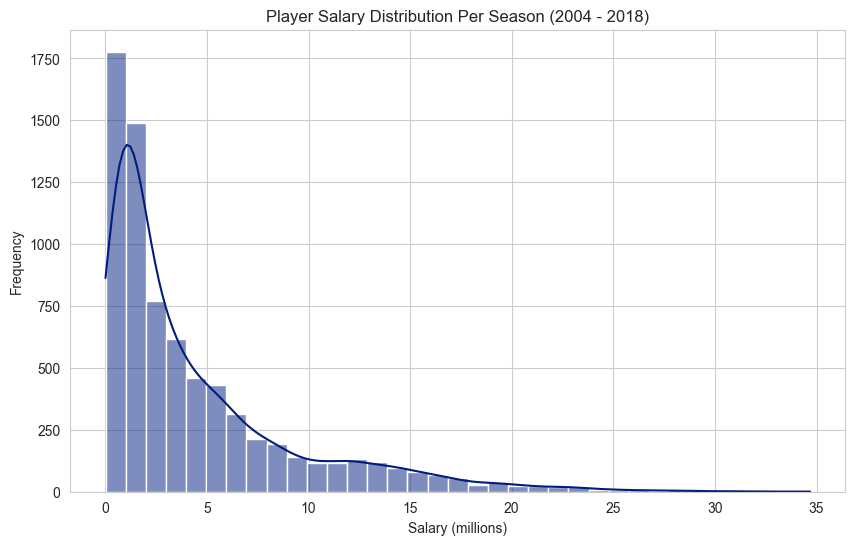

In [249]:
# Add styling.
sns.set_palette("dark")
sns.set_style("whitegrid")

# Plot the salary distribution.
plt.figure(figsize=(10, 6))
sns.histplot(filtered_salaries_df['salary'], bins=35, kde=True)
plt.title("Player Salary Distribution Per Season (2004 - 2018)")
plt.xlabel("Salary (millions)")
plt.ylabel("Frequency")
plt.show()

FINIDINGS: From the available data, the vast majority of players make less than 5 million dollars, with a relatively steep drop off. There are very few players that make extremely high salaries over 20 million per season.

Prep the Shots Data:

In [250]:
# Ensure numeric values for shot distance.
shots_df['SHOT_DISTANCE'] = pd.to_numeric(shots_df['SHOT_DISTANCE'], errors='coerce')

# Drop missing values.
shots_df = shots_df.dropna(subset=['SHOT_DISTANCE', 'SHOT_MADE'])

# Ensure bool for shot made.
shots_df['SHOT_MADE'] = shots_df['SHOT_MADE'].astype(bool)

# Get success rate by shot distance.
success_rate_by_distance = shots_df.groupby('SHOT_DISTANCE')['SHOT_MADE'].mean().reset_index()

# Make percent out of 100.
success_rate_by_distance['SHOT_MADE'] = success_rate_by_distance['SHOT_MADE'] * 100

shots_df

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,season
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,20.0,21.35,25,6,0,0,2004
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,POR,LAL,Made Shot,True,Driving Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,6,0,2,2004
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Missed Shot,False,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center,LC,16-24 ft.,13.3,24.45,23,6,0,9,2004
3,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,POR,LAL,Made Shot,True,Jump Shot,2PT Field Goal,Mid-Range,Left Side,L,16-24 ft.,16.4,13.95,18,6,0,31,2004
4,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,POR,LAL,Missed Shot,False,Jump Shot,2PT Field Goal,Mid-Range,Right Side,R,16-24 ft.,-15.8,7.85,16,6,0,55,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211702,2018,2017-18,1610612745,Houston Rockets,201935,James Harden,G,SG,10-17-2017,21700002,GSW,HOU,Missed Shot,False,Running Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center,C,8-16 ft.,-4.6,14.65,10,1,11,13,2018
211703,2018,2017-18,1610612739,Cleveland Cavaliers,201565,Derrick Rose,G,PG,10-17-2017,21700001,CLE,BOS,Missed Shot,False,Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,1.8,5.65,1,1,11,27,2018
211704,2018,2017-18,1610612744,Golden State Warriors,203110,Draymond Green,F,PF,10-17-2017,21700002,GSW,HOU,Missed Shot,False,Jump Shot,3PT Field Goal,Above the Break 3,Center,C,24+ ft.,-0.9,30.65,25,1,11,27,2018
211705,2018,2017-18,1610612745,Houston Rockets,201935,James Harden,G,SG,10-17-2017,21700002,GSW,HOU,Made Shot,True,Driving Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,1.0,6.85,1,1,11,47,2018


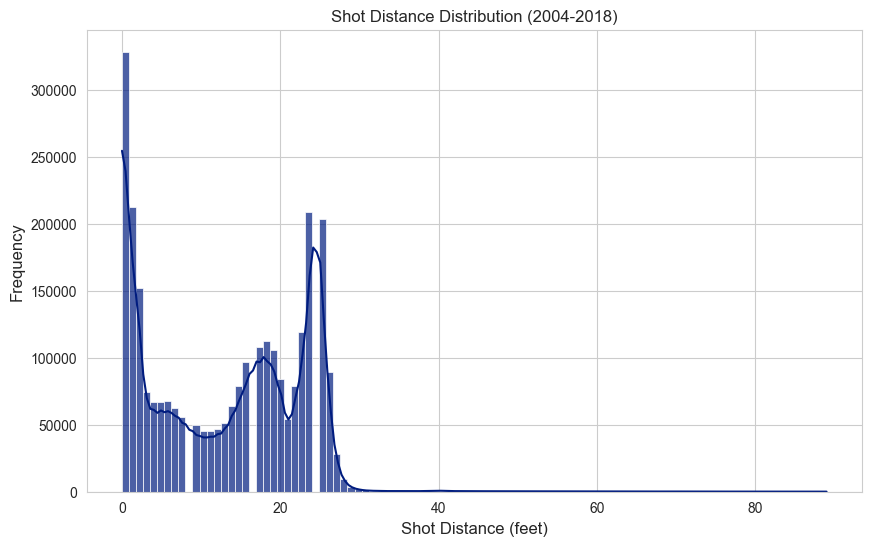

In [251]:
# Plot the shots distance distribution.
plt.figure(figsize=(10, 6))
sns.histplot(shots_df['SHOT_DISTANCE'], bins=100, kde=True, alpha=0.7)
plt.title("Shot Distance Distribution (2004-2018)")
plt.xlabel("Shot Distance (feet)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

FINDINGS: The most frequent 'shots' are most likely layups and dunks, with mid range shots being relatively balanced accross the distances. However, there is also a significant jump in shot frequency at the expected 3-point line, which is 22 feet from the goal for the NBA.

Prep the Shots Success to Distance Correlation:

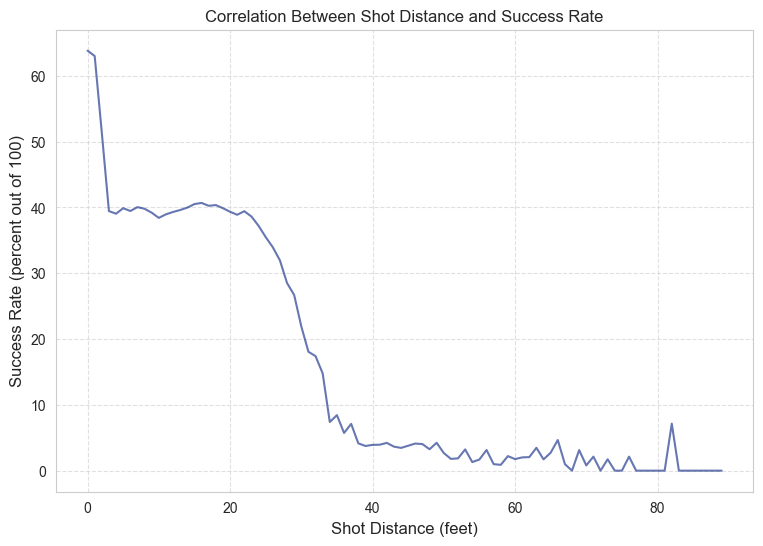

In [252]:
# Plot correlation between shot distance and success rate.
plt.figure(figsize=(9,6))
sns.lineplot(data=success_rate_by_distance, x='SHOT_DISTANCE', y='SHOT_MADE', alpha=0.6)
plt.title("Correlation Between Shot Distance and Success Rate")
plt.xlabel("Shot Distance (feet)", fontsize=12)
plt.ylabel("Success Rate (percent out of 100)", fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()

FINDINGS: The line chart presents that there is a steep drop from presumably dunks and layups, to when players begin shooting at a few feet of distance from the goal. It also shows that generally closer shots from about 2-20 feet do not have much variation. Once the player breaks 20 feet, the success rate again begins to drop before leveling for the most part.

***
### 3. Find the Correlation between Salary and Shots Made (By Season):

#### In the following section, data is filtered to only include shots that were made. Data is also broken down into independent seasons for each player. By comparing a player's salary for a season and a player's total shots made for that same season, the correlation between compensation and shots made is easier to identify.
***

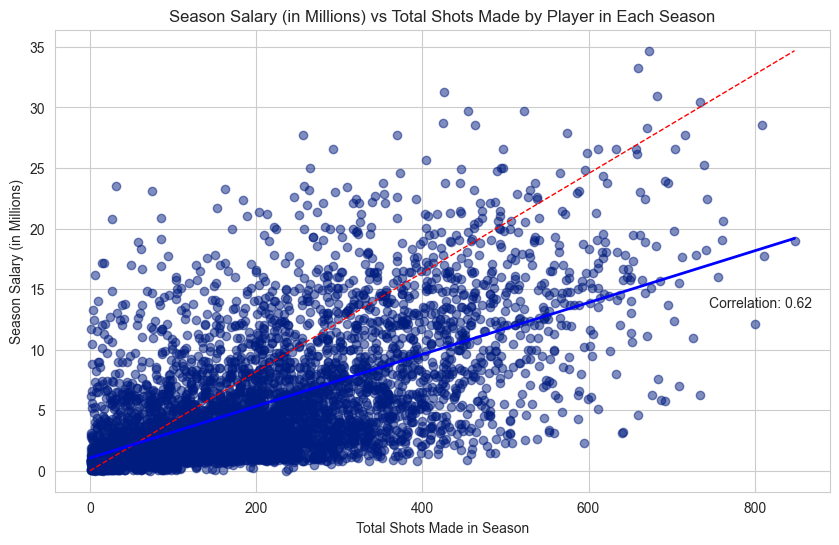

In [253]:
# Filter only shots that were made.
shots_made = final_merged_df[final_merged_df['SHOT_MADE'] == True]

# Group data by player and season and count total shots made in that specific season.
seasonal_stats = shots_made.groupby(['PLAYER_NAME', 'season']).agg(season_salary=('salary', 'first'), total_shots_made=('GAME_ID', 'count')).reset_index()

# Convert salary to millions.
seasonal_stats['season_salary'] = seasonal_stats['season_salary'] / 1_000_000

# Plot the relationship between season salary and total shots made.
plt.figure(figsize=(10, 6))
plt.scatter(seasonal_stats['total_shots_made'], seasonal_stats['season_salary'], alpha=0.5)

# Add a reference line to show a theoretical perfect correlation.
max_shots = seasonal_stats['total_shots_made'].max()
max_salary = seasonal_stats['season_salary'].max()
plt.plot([0, max_shots], [0, max_salary], color='red', linestyle='--', linewidth=1)

# Calculate and plot regression line
coeffs = np.polyfit(seasonal_stats['total_shots_made'], seasonal_stats['season_salary'], 1)
x_vals = np.linspace(0, max_shots, 100)
y_vals = np.polyval(coeffs, x_vals)
plt.plot(x_vals, y_vals, color='blue', linestyle='-', linewidth=2, label='Regression Line')

# Add correlation coefficient
correlation = seasonal_stats['total_shots_made'].corr(seasonal_stats['season_salary'])
plt.annotate(f"Correlation: {correlation:.2f}", xy=(745, 13.5))

# Add plot details.
plt.title("Season Salary (in Millions) vs Total Shots Made by Player in Each Season")
plt.xlabel("Total Shots Made in Season")
plt.ylabel("Season Salary (in Millions)")
plt.grid(True)
plt.show()

FINDINGS: A moderately strong correlation is presented. Players that typically make more shots, do also typically have higher salaries.

In [254]:
# Top 10 players/shots made in a single season.
top_10_shots = seasonal_stats.sort_values(by='total_shots_made', ascending=False).head(10)
print(top_10_shots[['PLAYER_NAME', 'season', 'total_shots_made', 'season_salary']])


            PLAYER_NAME  season  total_shots_made  season_salary
2885       Kevin Durant    2014               848      18.995624
2975        Kobe Bryant    2006               811      17.718750
4413  Russell Westbrook    2017               809      28.530608
4678      Stephen Curry    2016               800      12.112359
3153       LeBron James    2014               762      20.644400
3152       LeBron James    2013               761      19.067500
3150       LeBron James    2011               756      16.022500
771     Carmelo Anthony    2014               743      22.458000
155   Amar'e Stoudemire    2011               742      18.217705
2980        Kobe Bryant    2011               739      25.244493


In [255]:
# Top 10 players/salaries in a single season.
top_10_salaries = seasonal_stats.sort_values(by='season_salary', ascending=False).head(10)
print(top_10_salaries[['PLAYER_NAME', 'season', 'total_shots_made', 'season_salary']])

            PLAYER_NAME  season  total_shots_made  season_salary
4679      Stephen Curry    2017               673      34.682550
3156       LeBron James    2017               660      33.285709
4004       Paul Millsap    2017               426      31.269231
3155       LeBron James    2016               683      30.963450
2982        Kobe Bryant    2013               734      30.453805
1881     Gordon Hayward    2017               522      29.727900
504       Blake Griffin    2017               455      29.727900
3054         Kyle Lowry    2017               425      28.703704
4413  Russell Westbrook    2017               809      28.530608
3658        Mike Conley    2017               463      28.530608


***
### 4. Find the Correlation between Salary and Career WS (Career Win Shares):

#### In the following section, the players_salaries_df is modified to only contain the latest season available for each player, since the career_WS is a fixed value. From there, each is broken down to a decade to reduce the effect on data being skewed due to factors like inflation in later years. This data is then plotted in four separate subplots to view the correlation.
***

In [256]:
# Drop records without a career_WS value or where career_WS is 0.0 and ensure numeric conversion
latest_season_df = players_salaries_df.dropna(subset=['career_WS']).copy()
latest_season_df['career_WS'] = pd.to_numeric(latest_season_df['career_WS'], errors='coerce')
latest_season_df = latest_season_df[latest_season_df['career_WS'] > 0.0]

# Identify the latest season for each player and filter
latest_season_df = latest_season_df.loc[latest_season_df.groupby('_id')['season'].idxmax()]

# Ensure salary is in millions
latest_season_df['salary'] = latest_season_df['salary'] / 1_000_000

# Add the decade column.
latest_season_df['decade'] = (latest_season_df['season'] // 10) * 10

# Group the data by decade.
grouped_by_decade = latest_season_df.groupby('decade')

# View the latest_season_df before it is grouped by decade.
latest_season_df


,name,season,salary,draft_year,_id,career_WS,decade
211,Alaa Abdelnaby,1994,0.650000,1990,abdelal01,4.8,1990
7240,Kareem Abdul-Jabbar,1988,3.000000,1969,abdulka01,273.4,1980
8514,Mahmoud Abdul-Rauf,2000,0.798500,1990,abdulma02,25.2,2000
12333,Tariq Abdul-Wahad,2006,1.968750,1997,abdulta01,3.5,2000
11825,Shareef Abdur-Rahim,2009,6.600000,1996,abdursh01,71.2,2000
...,...,...,...,...,...,...,...
13117,Tyler Zeller,2017,1.709538,2012,zellety01,17.1,2010
13449,Wang Zhizhi,2004,0.745046,1999,zhizhwa01,2.1,2000
4839,George Zidek,1997,0.784200,1995,zidekge01,0.8,1990
672,Ante Zizic,2017,1.645200,2016,zizican01,3.0,2010


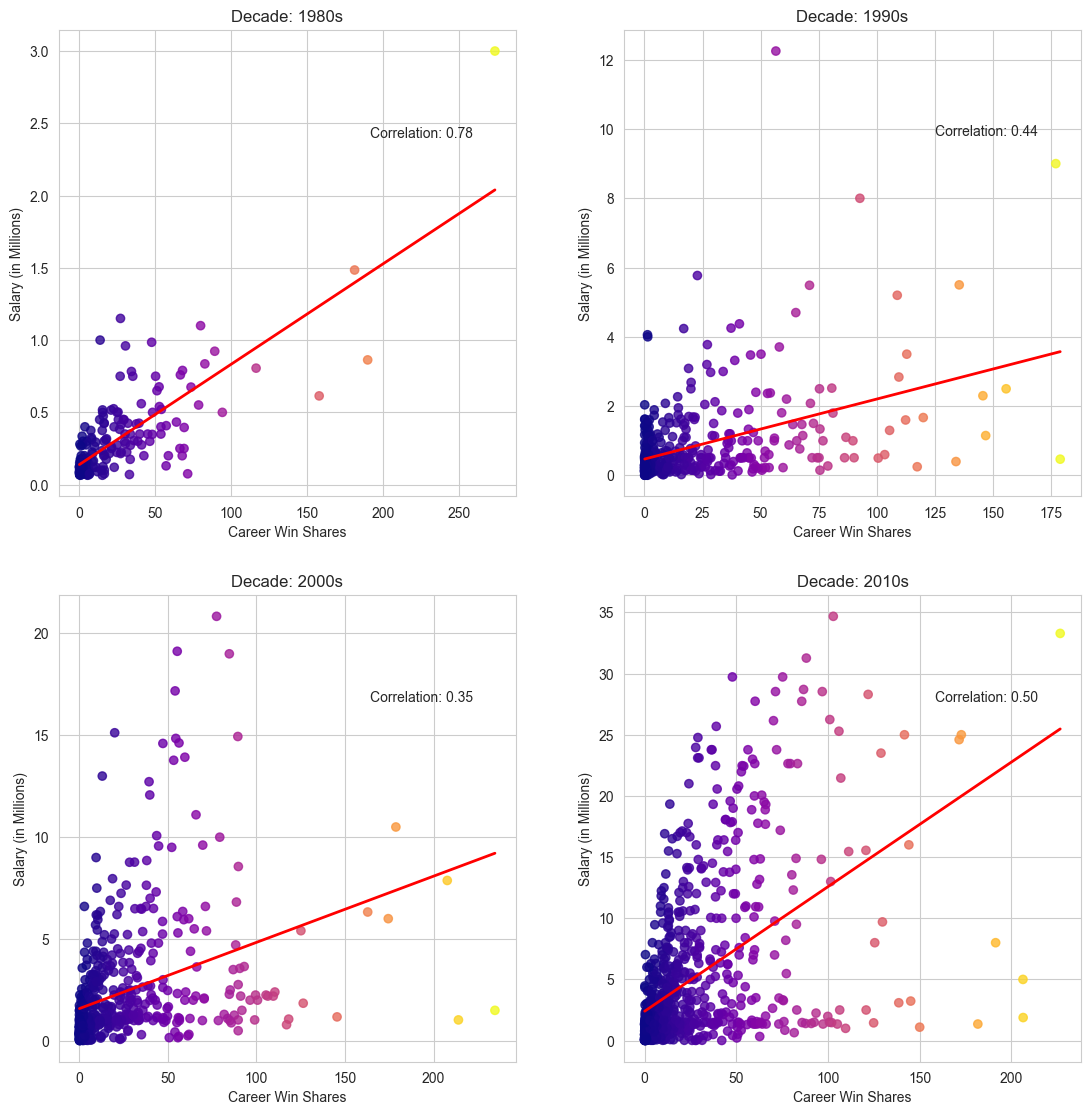

In [257]:
# Create subplots for a 2x2 grid for 4 decades of data.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes = axes.flatten()
fig.tight_layout(pad=5.0)

# Plot data for each decade.
for (decade, data), ax in zip(grouped_by_decade, axes):
    ax.scatter(data['career_WS'], data['salary'], alpha=0.8, c=data['career_WS'], cmap='plasma')
    ax.set_title(f"Decade: {decade}s")
    ax.set_xlabel("Career Win Shares")
    ax.set_ylabel("Salary (in Millions)")

    # Add regression line for each plot.
    if len(data) > 1:
        coeffs = np.polyfit(data['career_WS'], data['salary'], 1)
        x_vals = np.linspace(data['career_WS'].min(), data['career_WS'].max(), 100)
        y_vals = np.polyval(coeffs, x_vals)
        ax.plot(x_vals, y_vals, color='red', linestyle='-', linewidth=2, label='Regression Line')
        correlation = data['career_WS'].corr(data['salary'])
        ax.annotate(f"Correlation: {correlation:.2f}",
                    xy=(data['career_WS'].max() * 0.7, data['salary'].max() * 0.8))

plt.show()


FINIDINGS: There is a moderate correlation between salary and career win shares throughout all four decades. The strongest correlation is in the 1980s with a .78 and the weakest is in the 2000s with a .35. 

***
### 4. Find the Cost of Win Shares by Year:

#### In the following section, the latest_season_df is grouped by year to show the average cost (in salary) of a win share.
***

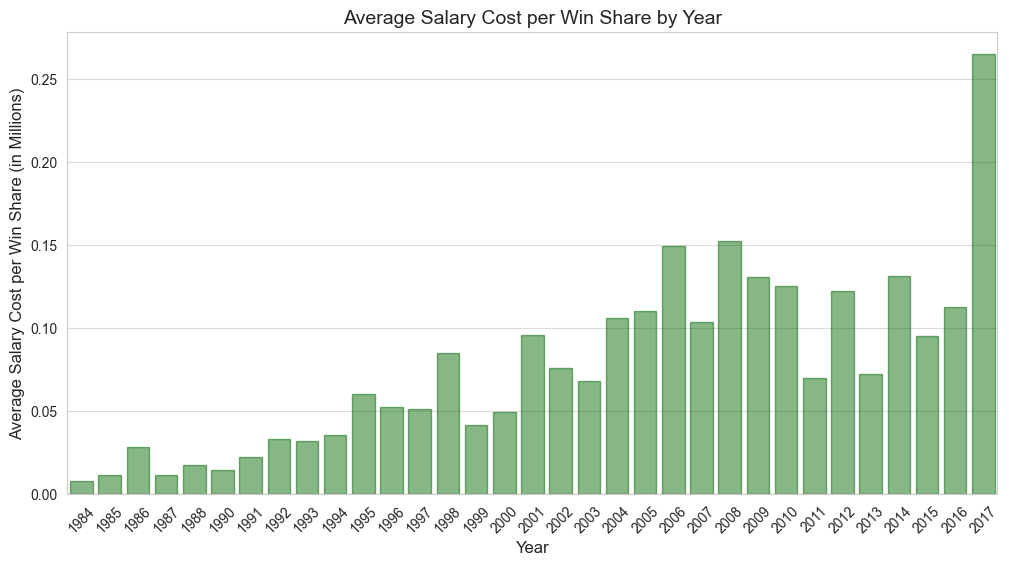

In [258]:
# Group data by year and calculate total salary and total win shares.
yearly_data = latest_season_df.groupby('season').agg(total_salary=('salary', 'sum'), total_win_shares=('career_WS', 'sum')).reset_index()

# Calculate average salary per win share.
yearly_data['avg_salary_per_ws'] = yearly_data['total_salary'] / yearly_data['total_win_shares']

# Plot the bar chart using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_data, x='season', y='avg_salary_per_ws', color='green', alpha=0.5, edgecolor='darkgreen')

# Add title and labels to chart.
plt.title('Average Salary Cost per Win Share by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Salary Cost per Win Share (in Millions)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()

FINDINGS: As presented by the chart above, there is an upward trend, but not more than might be expected from normal inflation over the years.